In [2]:
import sys
sys.path.append("../..")
sys.path.append("../../sac_ae")

In [3]:
import torch
import numpy as np
from IPython import display
from ipywidgets import Output, GridspecLayout
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_theme()

In [4]:
from sac_ae.env import make_envs
from sac_ae.model import make_model
from sac_ae.agent import make_agent
from utils.misc import eval_mode, VideoRecorder
from utils.argument import Arguments

In [5]:
def load_agent_and_args(path, device=torch.device('cpu'), model_name='model/best_model.pt'):
    args = Arguments(path + 'args.json')
    weights = torch.load(path + model_name, map_location=device)

    if args.agent == 'sac_state':
        agent_obs_shape = weights['actor.encoder.projection.projection.0.weight'].shape[1:]
        args.agent_image_size = agent_obs_shape[0]
    else:
        agent_obs_shape = (3*args.frame_stack, args.agent_image_size, args.agent_image_size)
    action_shape = np.array([4])

    model = make_model(agent_obs_shape, action_shape, args, device)
    agent = make_agent(model, device, action_shape, args)
    agent.load_model_from_dict(weights)
    return agent, args

In [6]:
def one_episode(agent, args, seed, video_name=None, compute_log_std=False):
    if video_name != None:
        video = VideoRecorder('./ensemble_analysis')

    env = make_envs(args, is_eval=True, use_state=True)
    env.seed(seed)
    obs = env.reset()
    
    if video_name != None:
        video.init()
        video.record(env)

    episode_reward, episode_cost = 0, 0
    actions = np.zeros(shape=(env._max_episode_steps, 4))
    
    log_std_list = np.zeros(shape=(env._max_episode_steps, 4))

    for step in range(env._max_episode_steps):
            with eval_mode(agent):
                action = agent.select_action(obs)
                actions[step] = action
                if compute_log_std:
                    obs_torch = torch.FloatTensor(obs).to(device).unsqueeze(0)
                    mu, pi, log_pi, log_std = agent.model.actor(obs_torch, compute_log_pi=True)
                    log_std_list[step] = log_std.detach().cpu().numpy()

            next_obs, reward, done, info = env.step(action)
            if video_name != None:
                video.record(env)
            episode_reward += reward
            if args.cost != 'no_cost':
                episode_cost += info['cost']

            obs = next_obs
    if video_name != None:
        video.save(video_name)
    print(f'Reward: {np.round(episode_reward, decimals=2)}, Cost: {np.round(episode_cost, decimals=2)}')
    if compute_log_std:
        return log_std_list
    return actions

In [7]:
def calc_success_rate(agent, args, seed, num_episodes=100, stochastic=False):
    env = make_envs(args, is_eval=True, use_state=args.agent == 'sac_state')
    env.seed(seed)
    
    num_successes, reward_sum, cost_sum = 0, 0, 0
    
    for i in range(num_episodes): 
        obs = env.reset()

        episode_reward, episode_cost = 0, 0
        done = False

        while not done:
                with eval_mode(agent):
                    if stochastic:
                        action = agent.sample_action(obs)
                    else:
                        action = agent.select_action(obs)

                next_obs, reward, done, info = env.step(action)
                episode_reward += reward
                if args.cost != 'no_cost':
                    episode_cost += info['cost']

                obs = next_obs
        reward_sum += episode_reward
        cost_sum += episode_cost
        success = False
        if info.get('is_success'):
            num_successes += 1
            success = True
    return num_successes / num_episodes, reward_sum / num_episodes, cost_sum / num_episodes

In [8]:
base_path = '../../../output/fetch-push-cost-small-fix-ensemble/SAC_ensemble_'
device = 'cpu'
actions_buffer = []
seed = np.random.randint(10000)
print(seed)

for i in range(3):
    path = base_path + f'{i}/'
    agent, args = load_agent_and_args(path)
    actions = one_episode(agent, args, seed, f'ensemble_{i}.mp4')
    actions_buffer.append(actions)
    #success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 100)
    #print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

5106
Creating window glfw
Reward: -12.01, Cost: 0.02
Creating window glfw
Reward: -20.65, Cost: 0.04
Creating window glfw
Reward: -19.3, Cost: 0


In [10]:
base_path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for i in range(4):
    path = base_path + f'{i}/'
    agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/1500000.pt')
    success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, False)
    print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

Seed: 6007
Model: 0, Success rate: 0.91, Mean reward: -3.57, Mean cost: 0.0
Model: 1, Success rate: 0.73, Mean reward: -6.23, Mean cost: 0.0
Model: 2, Success rate: 0.71, Mean reward: -6.37, Mean cost: 0.0
Model: 3, Success rate: 0.93, Mean reward: -4.34, Mean cost: 0.0


In [9]:
base_path = '../../../output/fetch-push-ae-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for stochastic in range(2):
    print(f'{"="*20} {"Stochastic" if stochastic else "Deterministic"} {"="*20}')
    for i in range(4):
        path = base_path + f'{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='best_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, stochastic)
        print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')

Seed: 466
==================== Deterministic ====================
Model: 0, Success rate: 0.94, Mean reward: -3.03, Mean cost: 0.0
Model: 1, Success rate: 0.76, Mean reward: -6.11, Mean cost: 0.0
Model: 2, Success rate: 0.88, Mean reward: -4.65, Mean cost: 0.0
Model: 3, Success rate: 0.82, Mean reward: -5.23, Mean cost: 0.0
==================== Stochastic ====================
Model: 0, Success rate: 0.95, Mean reward: -2.94, Mean cost: 0.0
Model: 1, Success rate: 0.75, Mean reward: -6.02, Mean cost: 0.0
Model: 2, Success rate: 0.89, Mean reward: -4.21, Mean cost: 0.0
Model: 3, Success rate: 0.83, Mean reward: -5.26, Mean cost: 0.0


In [14]:
%%time
base_path = '../../../output/fetch-push-cost-small-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for stochastic in range(2):
    print(f'{"="*20} {"Stochastic" if stochastic else "Deterministic"} {"="*20}')
    for i in range(3):
        path = base_path + f'{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='best_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, stochastic)
        print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')


Seed: 1097
==================== Deterministic ====================
Model: 0, Success rate: 0.74, Mean reward: -15.52, Mean cost: 2.31
Model: 1, Success rate: 0.41, Mean reward: -22.0, Mean cost: 1.98
Model: 2, Success rate: 0.68, Mean reward: -17.49, Mean cost: 2.49
==================== Stochastic ====================
Model: 0, Success rate: 0.74, Mean reward: -16.19, Mean cost: 2.49
Model: 1, Success rate: 0.41, Mean reward: -22.79, Mean cost: 2.93
Model: 2, Success rate: 0.64, Mean reward: -17.81, Mean cost: 2.06
CPU times: user 18min 55s, sys: 6.16 s, total: 19min 1s
Wall time: 15min 32s


# After tanh fix

In [12]:
%%time
base_path = '../../../output/fetch-push-cost-small-fix-ensemble/SAC_ensemble_'
seed = np.random.randint(10000)
print(f'Seed: {seed}')

for stochastic in range(2):
    print(f'{"="*20} {"Stochastic" if stochastic else "Deterministic"} {"="*20}')
    for i in range(3):
        path = base_path + f'{i}/'
        agent, args = load_agent_and_args(path, device=torch.device('cuda'), model_name='model/best_model.pt')
        success_rate, mean_reward, mean_cost = calc_success_rate(agent, args, seed, 500, stochastic)
        print(f'Model: {i}, Success rate: {np.round(success_rate, 2)}, Mean reward: {np.round(mean_reward, 2)}, Mean cost: {np.round(mean_cost, 2)}')


Seed: 4641
==================== Deterministic ====================
Model: 0, Success rate: 0.81, Mean reward: -12.7, Mean cost: 1.51
Model: 1, Success rate: 0.62, Mean reward: -17.11, Mean cost: 1.77
Model: 2, Success rate: 0.76, Mean reward: -14.94, Mean cost: 2.21
==================== Stochastic ====================
Model: 0, Success rate: 0.79, Mean reward: -12.95, Mean cost: 1.1
Model: 1, Success rate: 0.62, Mean reward: -17.56, Mean cost: 1.91
Model: 2, Success rate: 0.76, Mean reward: -14.42, Mean cost: 1.91
CPU times: user 18min 50s, sys: 6.41 s, total: 18min 56s
Wall time: 15min 27s


In [10]:
grid = GridspecLayout(1, 3)
for i in range(3):
    out = Output()
    with out:
        display.display(display.Video(f'ensemble_analysis/ensemble_{i}.mp4', html_attributes='loop autoplay'))
    grid[0, i] = out
grid

GridspecLayout(children=(Output(layout=Layout(grid_area='widget001')), Output(layout=Layout(grid_area='widget0…

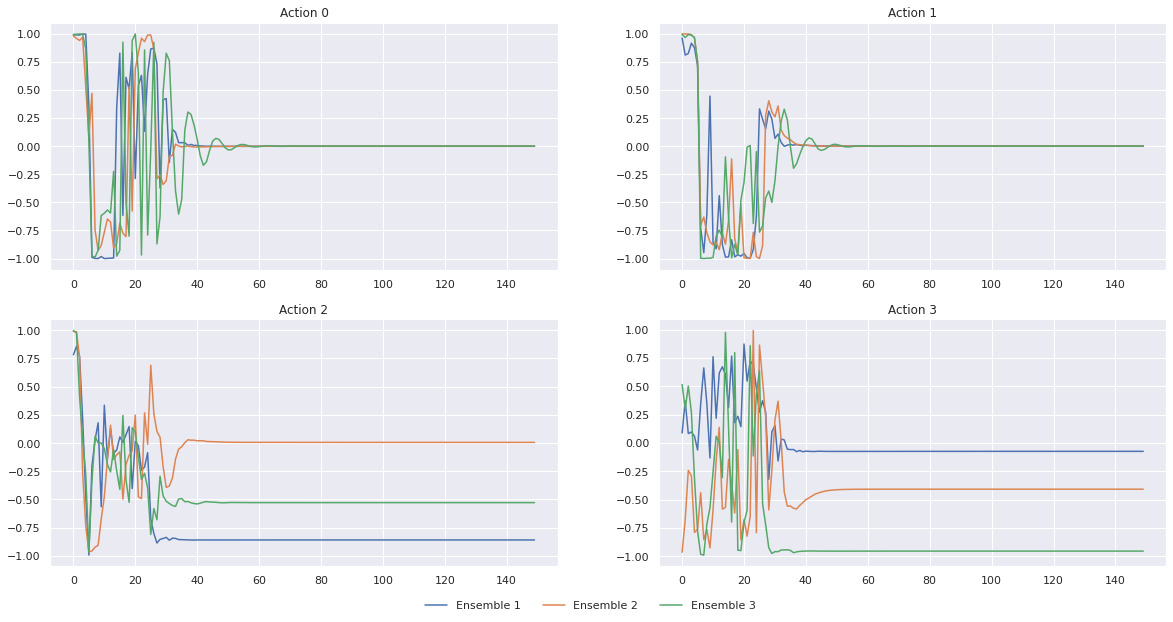

In [11]:
fig = plt.figure(figsize=(20, 10))
for action in range(4):
    ax = fig.add_subplot(2, 2, action+1)
    for i in range(3):
        sns.lineplot(data=actions_buffer[i][:, action], label=f'Ensemble {i}', legend=False)
    ax.set_title(f'Action {action}')
fig.legend(['Ensemble 1', 'Ensemble 2', 'Ensemble 3'])
sns.move_legend(fig, 'lower center', bbox_to_anchor=(.5, 0.05), ncol=3, title=None, frameon=False)
plt.savefig('ensemble_analysis/action_visualization.png', bbox_inches='tight', pad_inches=0)

In [7]:
device=torch.device('cuda')
path = '../../../output/fetch-push-cost-small-ensemble/SAC_ensemble_0/'
agent, args = load_agent_and_args(path, device=device)
env = make_envs(args, is_eval=True, use_state=True)

In [8]:
obs = env.reset()

In [9]:
obs_torch = torch.FloatTensor(obs).to(device).unsqueeze(0)

In [10]:
mu, pi, log_pi, log_std = agent.model.actor(obs_torch, compute_log_pi=True)

In [11]:
torch.exp(log_pi)

tensor([[859230.6250]], device='cuda:0', grad_fn=<ExpBackward0>)

In [106]:
log_stds = one_episode(agent, args, 0, compute_log_std=True)

Reward: -11.92, Cost: 3.17


# Mean std for one episode

In [114]:
np.exp(log_stds).mean(axis=0)

array([0.28497774, 0.25352208, 0.23818985, 0.25477541])

# Pi Calc Comparision

In [67]:
import torch.nn.functional as F
from sac_ae.model.misc import SquashedNormal

In [61]:
log_std_min = -10
log_std_max = 2

## My Implementation

In [90]:
x = agent.model.actor.encoder(obs_torch)
mu, log_std = agent.model.actor.mlp(x).chunk(2, dim=-1)
log_std = log_std_min + 0.5 * (log_std_max - log_std_min) * (log_std + 1)
log_std

tensor([[-0.8680, -0.6075, -1.2377, -1.4790]], device='cuda:0',
       grad_fn=<AddBackward0>)

In [91]:
torch.exp(log_std)

tensor([[0.4198, 0.5447, 0.2900, 0.2279]], device='cuda:0',
       grad_fn=<ExpBackward0>)

In [92]:
std = torch.exp(log_std)
pi_distribution = SquashedNormal(mu, std)
pi = pi_distribution.rsample()
log_pi = pi_distribution.log_prob(pi).sum(axis=-1, keepdim=True)
log_pi

tensor([[9.9510]], device='cuda:0', grad_fn=<SumBackward1>)

## Spinningup

In [116]:
x = agent.model.actor.encoder(obs_torch)
mu, log_std = agent.model.actor.mlp(x).chunk(2, dim=-1)
log_std = torch.clamp(log_std, log_std_min, log_std_max)
log_std

tensor([[0.5220, 0.5654, 0.4604, 0.4202]], device='cuda:0',
       grad_fn=<ClampBackward1>)

In [117]:
std = torch.exp(log_std)
pi_distribution = torch.distributions.normal.Normal(mu, std)
pi = pi_distribution.rsample()
log_pi = pi_distribution.log_prob(pi).sum(axis=-1)
log_pi -= (2*(np.log(2) - pi - F.softplus(-2*pi))).sum(axis=1)
log_pi

tensor([10.3221], device='cuda:0', grad_fn=<SubBackward0>)